In [209]:
import collections
import getopt
import math
import os
import shelve
import sys
import logging

from scipy import signal

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt
import re

import Spectrogram as sp
from utils import get_time_resolution, get_frequency_bins, plot_time_domain, extract_instrument_info, check_path


from Models.Autoencoder2DTripleStride import Autoencoder2DTripleStride
from Models.Autoencoder2DDoubleStride import Autoencoder2DDoubleStride
from Models.Autoencoder2DSingleStride import Autoencoder2DSingleStride
from Models.Autoencoder2DMelDoubleStride import Autoencoder2DMelDoubleStride
from Models.Autoencoder2DMelTripleStride import Autoencoder2DMelTripleStride
from Models.Autoencoder2DMelSingleStride import Autoencoder2DMelSingleStride

from NSynthDataset import NSynthDataset



In [210]:

#input_image = torch.ones((1, 1, 7, 7))

#kernel_size = 3
#kernel = torch.ones((1, 1, kernel_size, kernel_size))

#torch.conv2d(input_image, weight=kernel, stride=2, padding=0)

#r1 = torch.conv2d(c, weight=kernel, stride=1, padding=2)
#r2 = torch.conv_transpose2d(c, weight=kernel, stride=2, padding=0)

#print(r1)
#print(r2)


In [211]:
#Model = Autoencoder2DMelTripleStride
#model_path = "Training_full_2D_29_03_23_triple_strided_mel"
#Model = Autoencoder2DMelDoubleStride
#model_path = "Training_full_22_3_mel"
Model = Autoencoder2DMelSingleStride
model_path = "Mel_single_stride"

#Model = Autoencoder2DSingleStride
#model_path = "Training_08_03_strided"

#Model = Autoencoder2DTripleStride
#model_path = "Training_full_2D_17_2_23_strided"

#Model = Autoencoder2DDoubleStride
#model_path = "Training_23_2_23"

In [212]:
torch.set_num_threads(1)
so = open("data_train.log", "w", 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [213]:
def compute_spectrogram(signal, title, n_fft, fs, frame=None, show_spec=True, win_length=None, hop_length=None,
                        savefig=False, dataset='nsynth-test', use_mel=False):
    if not hop_length:
        hop_length = n_fft // 2
    if not win_length:
        win_length = n_fft
    if frame is not None:
        title = "%s_%d" % (title, frame)

    res = librosa.stft(signal, n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True, )
    times = librosa.times_like(res, sr=fs, hop_length=hop_length, n_fft=n_fft)
    freq = librosa.fft_frequencies(sr=fs, n_fft=n_fft)

    mag, phase = librosa.magphase(res)

    if use_mel:
        mel = librosa.feature.melspectrogram(S=mag**2, sr=fs)
        ref = np.max(mel)
        mel_db = librosa.power_to_db(mel, amin=1e-13, ref=ref, top_db=120)

        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=fs, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt_title="Mel-frequency %s" % title
        ax.set(title=plt_title)

    else:
        ref = np.max(mag)
        mag_db = librosa.power_to_db(mag, amin=1e-13, ref=ref, top_db=120)
        plt.pcolormesh(times, freq, mag_db, cmap='inferno')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time in sec')
        plt.colorbar(format='%-2.0f dB')
        plt.title(title)

    # to be tried out in further process during thesis
    #mel = librosa.feature.melspectrogram(S=mag)
    # mel = librosa.amplitude_to_db(mel, ref=np.min)
    # librosa.display.specshow(mel, x_axis='time', y_axis='mel')
    # plt.colorbar(format='%-2.0f dB')
    # plt.show()

    # try to apply log to magnitude
    # func = lambda x: math.log10(x) if x != 0 else -12
    # func = np.vectorize(func)
    # mag = func(mag)

    # power to db conversion that worked out best


    # nsynth implementation with normalized db --> output doesn't sound that good as without normalization
    # mag_squared = mag**2
    # ref = np.max(mag_squared)
    # mag_db = (librosa.power_to_db(mag_squared, amin=1e-13, ref=ref, top_db=120)/120.) + 1

    instrument = re.search("[a-z]+_[a-z]+", title).group(0)



    if savefig:
        if use_mel:
            path = './Samples/%s/mel_specs/%s' % (dataset, instrument)
        else:
            path = './Samples/%s/specs/%s' % (dataset, instrument)
        check_path(path)
        plt.savefig("%s/%s.png" % (path, title), dpi=200)
        plt.close()
    if show_spec:
        plt.show()

    if use_mel:
        return sp.Spectrogram(title, instrument, freq, times, mel_db, phase, ref)
    else:
        return sp.Spectrogram(title, instrument, freq, times, mag_db, phase, ref)




In [214]:
def pre_process(instrument_family=None, instrument_source=None, dataset_type='nsynth-train', framed=False, use_mel=False):


    nsynth = NSynthDataset('examples.json', 'Samples/%s' % dataset_type)
    

    #nsynth.shrink_to_single_instrument(4, 2)  # Extracting Keyboard_Synthetic
    if instrument_family is not None and instrument_source is not None:
        nsynth.shrink_to_single_instrument(instrument_family, instrument_source)  # Extracting Guitar Acoustic



    _, _, sr = nsynth[0]

    frame_size_millis = 20
    hann_window_length_sec = frame_size_millis / 1000
    hann_window_length = int(sr * hann_window_length_sec)
    hann_window = np.hanning(hann_window_length)
    window_hop = int(hann_window_length / 2)

    length = len(nsynth)
    for i in range(0, length):
        s, t, sr = nsynth[i]
        s, idx = librosa.effects.trim(s)  # cut silence at the end
        pad = hann_window_length - idx[1] % window_hop  # calculate the padding to multiple of hop distance including one extra frame for overlap
        s = librosa.util.fix_length(s, size=idx[1] + pad)  # fixes length to multiple of hop distance
        s = np.pad(s, (window_hop, 0), 'constant')
        #plot_time_domain(s, t, 'SignalPlots', persist=False) # plots whole time domain signal

        if framed:
            # version with calculating frames in advance
            frames = librosa.util.frame(s, frame_length=hann_window_length, hop_length=window_hop, axis=0)
            for j, frame in enumerate(frames):
                if frame.max() == 0 and frame.min() == 0: break  # discard empty frame
                frame = frame * hann_window
                plot_time_domain(frame, t, 'SignalPlots/', persist=True, frame=j)
                spec = compute_spectrogram(frame, t, 512, sr, savefig=True, frame=j, show_spec=False)
                #spec.persist()
        else:
            #plot_time_domain(s, t, 'SignalPlots', persist=True)
            spec = compute_spectrogram(s, t, 1024, sr, savefig=True, show_spec=False, dataset=dataset_type, hop_length=1024//2, use_mel=use_mel)
            spec.persist(dataset_type)
            print("Persisted %d of %d" % (i+1, length), end='\r')

### Call for pre-processing

In [215]:
#pre_process(3,0, 'nsynth-test') #Pre process keybboard synthetic

#pre_process(3,0, 'nsynth-test', use_mel=True)
#pre_process(6,1, 'nsynth-test', use_mel=True)
#pre_process(1,0, 'nsynth-test', use_mel=True)

In [216]:
#pre_process(3,1, 'nsynth-test') # guitar electronic
#pre_process(3,0, 'nsynth-test') # guitar acoustic
#print("Hello From Notebook")
#pre_process(6,1, 'nsynth-test') # organ electronic

#pre_process(0,1, 'nsynth-test')
#pre_process(0,1, 'nsynth-valid') # bass electronic

#pre_process(0,1, 'nsynth-train')
#print("")
#pre_process(6,1, 'nsynth-test')
#print("")
#pre_process(2,0, 'nsynth-test') # flute
#print("")

#pre_process(dataset_type='nsynth-test', use_mel=True) # pre process all
#pre_process(dataset_type='nsynth-valid', instrument_family=3, instrument_source=0)

### Training Step 

In this part the training will be defined and started

In [217]:
import time

def fit_model(criterion, dataLoader, v_dataLoader, model, optimizer, epochs, scheduler, persist=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("")
    print("Device: %s" % device)
    print("")
    
    min_valid_loss = np.inf
    
    
    for epoch in range(epochs):
        start = time.time()
        loss = 0
        feature = 0
        for batch_features, targ in dataLoader:

            batch_features = batch_features.to(device)

            optimizer.zero_grad()

            outputs = model(batch_features)

            train_loss = criterion(outputs, batch_features)

            train_loss.backward()

            optimizer.step()

            loss += train_loss.item()

            #print("Feature: %d, loss %.6f" % (feature, train_loss.item()))

            feature += 1

            print("Feature %d / %d" % (feature, len(dataLoader)), end='\r')
        loss = loss / len(dataLoader)
        
        
        
        print("")
        
        end = time.time()
        diff = (end - start)
        print('Needs %.3f Seconds' % diff)

        
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        
        if epoch > 0:
            print(f"Current LR: {scheduler.state_dict()['_last_lr']}")
        #print(scheduler.state_dict())
        
        val_loss = 0.0
        if v_dataLoader is not None:
            print("Validating ...")

            
            for v_batch_features, v_targ in v_dataLoader:

                v_batch_features = v_batch_features.to(device)

                outputs = model(v_batch_features)
                feature_loss = criterion(outputs, v_batch_features)

                val_loss += feature_loss.item()

            val_loss = val_loss/len(v_dataLoader)
            print("Validation Score: %.6f" % val_loss)
            if min_valid_loss > val_loss:
                print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{val_loss:.6f})')
                min_valid_loss = val_loss
                
            scheduler.step(val_loss)
        else:
            scheduler.step(loss)
        print(f"New LR: {scheduler.state_dict()['_last_lr']}")
        
        
        if persist:
            torch.save(model, "./Models/Trained/Training_9_2_23_Valid/Baseline_Epoch_%d_Loss_%.3f_Val_%.3f" % (epoch, loss, val_loss))
        
        
        print("------------------------------------------------")

    if persist:
        torch.save(model, "Models/Trained/Training_9_2_23_Valid/Trained_Best")

training the preliminary model

In [218]:
def train(epochs):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Model().to(device)


    optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=0.9999, eps=1e-8)
    #optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Params: %s " % pytorch_total_params)

    #criterion = nn.BCELoss()
    criterion = nn.MSELoss()

    specs = np.load("train_specs_full.npy", mmap_mode='r+')

    #specs = sp.concatenate_spectrograms_2D("nsynth-valid_1024", cut_silence=True, overlap=True)


    print("")
    print(specs.shape)

    #v_specs = np.load("valid_specs.npy")
    v_specs = sp.concatenate_spectrograms_2D("nsynth-valid_mel", cut_silence=True, overlap=True)
    np.random.shuffle(v_specs)

    #print("")

    tensor = torch.from_numpy(specs)
    dataset = TensorDataset(tensor, tensor)
    dataLoader = DataLoader(dataset, 32, num_workers=12, pin_memory=True, shuffle=True)

    v_tensor = torch.Tensor(v_specs)
    v_dataset = TensorDataset(v_tensor, v_tensor)
    v_dataLoader = DataLoader(v_dataset, 32, num_workers=12, pin_memory=True, shuffle=True)

    fit_model(criterion, dataLoader, v_dataLoader, model, optimizer, epochs, scheduler, persist=True)


In [219]:
#specs = sp.concatenate_spectrograms_2D("nsynth-train_1024", cut_silence=True, overlap=True)

#np.save("train_specs_p2.npy", specs)

#v_specs = sp.concatenate_spectrograms_2D("nsynth-valid_1024", cut_silence=True, overlap=True, limit=1000)

#np.save("valid_specs")

In [220]:
#specs_pt1 = np.load("train_specs_p1.npy", mmap_mode='r')
#print("loaded first")
#specs_pt2 = np.load("train_specs_p2.npy",mmap_mode='r')
#
#print("now concatenating")
#specs = np.concatenate((specs_pt1, specs_pt2))

#print("concatenated")




In [221]:
#train(1000)

In [222]:
def convert_to_dict(training_folder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "./Models/Trained/%s/Trained_Best" % training_folder
    model = torch.load(model_path, map_location=device)

    torch.save(model.state_dict(), "%s.pt" % model_path)



In [223]:
#convert_to_dict("Training_14_02_23_2DOverlap")

In [224]:
def test_model(training_folder, dataset, instrument=None, pitch=None, shuffle=True):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "./Models/Trained/%s/Trained_Best.pt" % training_folder
    model = Model()
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval()
    for param in model.parameters():
        param.grad = None
    torch.set_flush_denormal(True)


    if instrument is not None:
        specs, targets = sp.concatenate_spectrograms_2D(dataset, [instrument], cut_silence=True, desired_pitch=pitch, overlap=True)
    else:
        specs, targets = sp.concatenate_spectrograms_2D(dataset, cut_silence=True, desired_pitch=pitch, overlap=True)
    if len(specs) == 0: return

    if shuffle: np.random.shuffle(specs)
    tensor = torch.Tensor(specs)
    testset = TensorDataset(tensor)
    loader = DataLoader(testset)
    

    criterion = nn.MSELoss()
    print("")
    print(device)
    
    with torch.no_grad():

        feature = 1
        test_loss = 0.0
        for batch_features in loader:
            
            features = batch_features[0].to(device)
            output = model.forward(features)
            
            loss = criterion(output, features)
            
            test_loss += loss
            print("Feature %d / %d" % (feature, len(loader)), end='\r')
            feature += 1
            
        test_loss = test_loss/len(loader)
        
        print("Test Score: %.6f pitch: %s" % (test_loss, pitch))
            
    


The following cell is for evaluating scores regarding specific pitches

In [225]:
# test_model(model_path, 'nsynth-test_mel', pitch='030')
# test_model(model_path, 'nsynth-test_mel', pitch='035')
# test_model(model_path, 'nsynth-test_mel', pitch='040')
# test_model(model_path, 'nsynth-test_mel', pitch='045')
# test_model(model_path, 'nsynth-test_mel', pitch='050')
# test_model(model_path, 'nsynth-test_mel', pitch='055')
# test_model(model_path, 'nsynth-test_mel', pitch='060')
# test_model(model_path, 'nsynth-test_mel', pitch='065')
# test_model(model_path, 'nsynth-test_mel', pitch='070')
# test_model(model_path, 'nsynth-test_mel', pitch='075')
# test_model(model_path, 'nsynth-test_mel', pitch='080')
# test_model(model_path, 'nsynth-test_mel', pitch='085')
# test_model(model_path, 'nsynth-test_mel', pitch='090')
# test_model(model_path, 'nsynth-test_mel', pitch='095')
# test_model(model_path, 'nsynth-test_mel', pitch='100')

In [226]:
# test_model(model_path, 'nsynth-test_1024')

In [227]:
def encode(training_folder, pitch=None, make_plot=True, instruments=None, one_dimension=True, plot_as_image=True, samples=None, use_mel=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = "./Models/Trained/%s/Trained_Best.pt" % training_folder
    #model = torch.load(model_path, map_location=device)
    model = Model()
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval()

    for param in model.parameters():
        param.grad = None
    torch.set_flush_denormal(True)

    if use_mel:
        dataset = 'nsynth-test_mel'
    else:
        dataset = 'nsynth-test_1024'

    specs, targets, phases, power_refs  = sp.concatenate_spectrograms_2D(dataset, instruments, all_data=True, cut_silence=True, desired_pitch=pitch, overlap=True, samples=samples)

    tensor = torch.Tensor(specs)
    testset = TensorDataset(tensor)
    loader = DataLoader(testset, num_workers=6)

    print("")
    embedding_dict = {}
    with torch.no_grad():

        feature_idx = 0
        instrument_idx = 0
        for feature in loader:

            feature = feature[0].to(device)

            encoding = model.encode(feature)

            if embedding_dict.get(targets[feature_idx]) is None:
                embedding_dict[targets[feature_idx]] = {}
                embedding_dict[targets[feature_idx]]['emb'] = []
                embedding_dict[targets[feature_idx]]['power_ref'] = power_refs[instrument_idx]
                instrument_idx += 1

            embedding_dict[targets[feature_idx]]['emb'].append(encoding[0,0].data.cpu().numpy().squeeze())

            print("Feature %d / %d" % (feature_idx, len(loader)), end='\r')
            feature_idx += 1

    print("")



    if make_plot:
        plot_embedding(embedding_dict, one_dimension, plot_as_image, use_mel)

    return embedding_dict

def plot_embedding(embedding_dict, one_dimension, plot_as_image, use_mel):

    if use_mel:
        basefolder = "Output_mel/embeddings/%s" % model_path
    else:
        basefolder = "Output/embeddings/%s" % model_path

    check_path(basefolder)

    for key in embedding_dict:

            if one_dimension:
                if plot_as_image:
                    emb = np.array(embedding_dict[key]['emb'])
                    embedding = emb.transpose()
                    y_scale = np.array([i for i in range(0, embedding.shape[0])])
                    x_scale = np.array([i for i in range(0, embedding.shape[1])])

                    plt.pcolormesh(x_scale, y_scale, embedding, cmap='inferno', shading='auto')
                    plt.colorbar()
                    plt.title("Embedding of %s" % key)

                    plt.xlabel("Encoder output vectors")
                    plt.savefig("%s/%s" % (basefolder, key), dpi=200)
                    plt.close()

                else:
                    pt = 1
                    for v in np.array(embedding_dict[key]['emb']):

                        plt.stem(v)
                        plt.title("Embedding of %s pt %s" % (key, pt))
                        plt.savefig("%s/%s_%s" % (basefolder, key, pt), dpi=200)
                        plt.close()
                        pt += 1

            else:
                pt = 1
                for emb in np.array(embedding_dict[key]['emb']):
                    embedding = emb.transpose()
                    y_scale = np.array([i for i in range(0, embedding.shape[0])])
                    x_scale = np.array([i for i in range(0, embedding.shape[1])])

                    plt.pcolormesh(x_scale, y_scale, embedding, cmap='inferno', shading='auto')
                    plt.colorbar()
                    plt.title("Embedding of %s" % key)

                    plt.xlabel("Encoder output vectors")
                    plt.savefig("%s/%s_%s" % (basefolder, key, pt), dpi=200)
                    plt.close()

                    pt += 1

def decode_interpolated(training_folder, z, title, power_refs, key_a=None, key_b=None, apply_energy_correction=True, use_mel=False, i_rate=0.5):
    print("Decode")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = "./Models/Trained/%s/Trained_Best.pt" % training_folder
    model = Model()
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval()

    for param in model.parameters():
        param.grad = None
    torch.set_flush_denormal(True)

    decodable = z.astype(np.float32)[:, np.newaxis, np.newaxis, :]

    tensor = torch.tensor(decodable)
    dataset = TensorDataset(tensor)
    loader = DataLoader(dataset, num_workers=6)
    output_spec = []
    with torch.no_grad():


        count = 1
        for feature in loader:

            feature = feature[0].to(device)

            output = model.decode(feature)
            if len(output_spec) == 0:
                output_spec.extend(output[0,0].data.cpu().numpy())
            else:
                spec = output[0,0].data.cpu().numpy()
                output_spec[-2:] = (output_spec[-2:] + spec[:-1])/2
                output_spec.append(spec[-1])
            print("Feature %d / %d" % (count, len(loader)), end='\r')
            count += 1

    print("")
    output = np.array(output_spec).transpose()

    #plot_reconstructions(output, '%s_output_spec_%.1f' % (title, i_rate), interpolated=True, use_mel=use_mel)
    reconstruct_audio(output, power_refs, '%s_output_%.1f' % (title, i_rate), apply_energy_correction, interpolated=True, key_a=key_a, key_b=key_b, use_mel=use_mel)
    reconstruct_audio(output, power_refs, '%s_output_%.1f' % (title, i_rate), False, interpolated=True, key_a=key_a, key_b=key_b, use_mel=use_mel)





In [230]:
def extract_energy(n_fft, dataset, use_mel=False):

    ds = NSynthDataset('examples.json', 'Samples/%s' % dataset)

    hop_length = n_fft // 2
    win_length = n_fft

    energy_dict = {}

    for i in range(0, len(ds)):
        s, t, sr = ds[i]

        res = librosa.stft(s, n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True, )
        mag, _ = librosa.magphase(res)

        if use_mel:
            mag = librosa.feature.melspectrogram(S=mag**2, sr=sr)

        if energy_dict.get(t) is None:
            energy_dict[t] = []

        for f_vec in mag.transpose():
            energy_sum = f_vec.sum()
            energy_dict[t].append(energy_sum)

        print("Calculated energy for spec %d of %d" % (i, len(ds)), end='\r')


    print("")
    return energy_dict


In [231]:
energy_dict = extract_energy(1024, 'nsynth-test', use_mel=False) ### extracting energy values of all frequency vectors per sample for later energy correction

In [232]:
import soundfile


def reconstruct(training_folder, instruments=None, pitch=None, apply_energy_correction=True, use_mel=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = "./Models/Trained/%s/Trained_Best.pt" % training_folder
    model = Model()
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    #model = torch.load(model_path, map_location=device)
    model.eval()

    for param in model.parameters():
        param.grad = None
    torch.set_flush_denormal(True)

    specs, targets, phases, power_refs  = sp.concatenate_spectrograms_2D("nsynth-test_1024", instruments=instruments, all_data=True, cut_silence=True, desired_pitch=pitch, overlap=True)

    tensor = torch.Tensor(specs)
    testset = TensorDataset(tensor)
    loader = DataLoader(testset, num_workers=6, )

    criterion = nn.MSELoss()
    print("")

    spec_dict = {}

    with torch.no_grad():

        pitch_loss = 0.0
        target_idx = 0
        instrument_idx = 0
        for batch_features in loader:

            features = batch_features[0].to(device)
            output = model.forward(features)
            loss = criterion(output, features)

            if spec_dict.get(targets[target_idx]) is None:
                spec_dict[targets[target_idx]] = {}
                spec_dict[targets[target_idx]]['spec'] = []
                spec_dict[targets[target_idx]]['spec'].extend(output[0,0].data.cpu().numpy())
                spec_dict[targets[target_idx]]['power_ref'] = power_refs[instrument_idx]
                spec_dict[targets[target_idx]]['phase'] = phases[instrument_idx]
                spec_dict[targets[target_idx]]['loss'] = [loss]

                instrument_idx += 1
            else:
                spec = output[0,0].data.cpu().numpy()
                spec_dict[targets[target_idx]]['spec'][-2:] = (spec_dict[targets[target_idx]]['spec'][-2:] + spec[:-1])/2
                spec_dict[targets[target_idx]]['spec'].append(spec[-1])
                #spec_dict[targets[target_idx]]['spec'].extend(spec) # if no overlap

                spec_dict[targets[target_idx]]['loss'].append(loss)

            pitch_loss += loss


            print("Feature %d / %d" % (target_idx, len(loader)), end='\r')


            target_idx += 1

        pitch_loss /= len(loader)
        print("")
        print("MSE-Loss: %.5f" % pitch_loss)


    for key in spec_dict:

        feature_loss = np.array(spec_dict[key]['loss'])
        spec_loss = feature_loss.mean()

        print("Loss for sample %s is %.5f" % (key, spec_loss ))

        spec = np.array(spec_dict[key]['spec']).transpose()



        phases = np.array(spec_dict[key]['phase'])
        #phases = phases.transpose()
        power_ref = np.array(spec_dict[key]['power_ref'])
        reconstruct_audio(spec, power_ref, key, apply_energy_correction, use_mel=use_mel, phase=None)
        reconstruct_audio(spec, power_ref, key, apply_energy_correction=False, use_mel=use_mel, phase=None)


def plot_reconstructions(reconstruction, title, interpolated=False, use_mel=False):

    from utils import get_frequency_bins, get_time_resolution

    if use_mel:
        basepath = "Output_mel"

        fig, ax = plt.subplots()
        img = librosa.display.specshow(reconstruction, x_axis='time', y_axis='mel', sr=16000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt_title="Mel-frequency %s" % title
        ax.set(title=plt_title)

    else:
        basepath = "Output"
        times = get_time_resolution(512, reconstruction.shape[1], 16000)
        freq = get_frequency_bins(16000, 512)

        plt.pcolormesh(times, freq, reconstruction, cmap='inferno', shading='auto')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time in sec')
        plt.colorbar(format='%-2.0f dB')
        plt.title(title)



    if interpolated:
        p = './%s/specs/%s/interpolated' % (basepath, model_path)
        check_path(p)
        plt.title("Output spectrogram")
        plt.savefig('%s/%s.png' % (p, title), dpi=200)
    else:
        p = './%s/specs/%s' % (basepath, model_path)
        check_path(p)
        plt.savefig('%s/%s.png' % (p, title), dpi=200)
    plt.close()

def equalize_energy(energy_o, mag_t):

    for idx, v in enumerate(mag_t):
        energy_sum = v.sum()
        factor = energy_o[idx]/energy_sum
        v *= factor

def reconstruct_audio(mag, power, title, apply_energy_correction, phase=None, interpolated=False, key_a=None, key_b=None, use_mel=False, is_original=False):

    mag = librosa.db_to_power(mag, ref=power)
    mag_t = mag.transpose()

    if apply_energy_correction:

        if interpolated:
            energy_o_a = np.array(energy_dict[key_a][:len(mag_t)])
            energy_o_b = np.array(energy_dict[key_b][:len(mag_t)])
            mean_energy = (energy_o_a+energy_o_b)/2
            equalize_energy(mean_energy, mag_t)
        else:

            energy_o = energy_dict[title]
            equalize_energy(energy_o, mag_t)
        title = "%s_ec" % title

    plot_reconstructions(librosa.power_to_db(mag, amin=1e-13, ref=power, top_db=120), title, use_mel=use_mel, interpolated=interpolated)

    if use_mel:
        if phase is not None:
            mag = librosa.feature.inverse.mel_to_stft(mag, n_fft=1024, sr=16000)
            mag_phase = mag*phase[:,:-1]
            sig = librosa.istft(mag_phase, n_fft=1024, hop_length=512, win_length=1024)
            sig_path = 'Output_mel/SignalPlots/%s' % model_path
            wav_path = 'Output_mel/wav/%s' % model_path
            check_path(sig_path)
            check_path(wav_path)
            plot_time_domain(sig, title, basepath=sig_path, persist=True)
            filename = '%s/%s.wav' % (wav_path, title)
            soundfile.write(filename, sig, 16000)
            return

        sig_griff = librosa.feature.inverse.mel_to_audio(mag, n_fft=1024, hop_length=512, win_length=1024, sr=16000)
        plot_path = 'Output_mel/SignalPlots'
        sig_path = 'Output_mel/wav'

    else:
        if phase is not None:
            mag_phase = mag * phase[:,:-1]
            sig = librosa.istft(mag_phase, n_fft=1024, hop_length=512, win_length=1024)
            sig_path = 'Output/SignalPlots/%s' % model_path
            wav_path = 'Output/wav/%s' % model_path
            check_path(sig_path)
            check_path(wav_path)
            plot_time_domain(sig, title, basepath=sig_path, persist=True)
            filename = '%s/%s.wav' % (wav_path, title)
            soundfile.write(filename, sig, 16000)
            return

        sig_griff = librosa.griffinlim(mag, n_fft=1024, hop_length=512, win_length=1024)

        plot_path = 'Output/SignalPlots'
        sig_path = 'Output/wav'

    plot_path = os.path.join(plot_path, model_path)
    sig_path = os.path.join(sig_path, model_path)

    if interpolated:
        plot_path = os.path.join(plot_path, 'interpolated')
        sig_path = os.path.join(sig_path, 'interpolated')



    check_path(plot_path)
    check_path(sig_path)

    if is_original:
        source = "o"
    else:
        source = "gl"

    plot_time_domain(sig_griff, "%s_%s.png" % (title, source), basepath=plot_path, persist=True)
    filename_gf = '%s_%s.wav' % (title, source)
    soundfile.write(os.path.join(sig_path, filename_gf), sig_griff, 16000)


In [233]:
# reconstruct(model_path, pitch='030', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)
#
# reconstruct(model_path, pitch='080', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)

# reconstruct(model_path, pitch='100', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)

In [234]:
# reconstruct(model_path, pitch='040', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)
#
# reconstruct(model_path, pitch='050', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)
#
# reconstruct(model_path, pitch='070', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=True)


reconstruct(model_path, pitch='060', instruments=['guitar_acoustic', 'brass_acoustic', 'keyboard_synthetic'], apply_energy_correction='True', use_mel=False)

#spec = sp.getSpectrogram("SpectrogramData.nosync/nsynth-test_mel/bass_synthetic", "bass_synthetic_009-035-025.db")


#reconstruct_audio(spec.magnitude, spec.ref_power, spec.name, True, use_mel=True, is_original=True)


Concat Process: 14/14
Feature 1400 / 1401
MSE-Loss: 9.39651
Loss for sample brass_acoustic_016-060-075 is 9.41475
Loss for sample brass_acoustic_015-060-127 is 8.65458
Loss for sample brass_acoustic_059-060-075 is 8.33865
Loss for sample guitar_acoustic_030-060-075 is 14.82635
Loss for sample guitar_acoustic_015-060-050 is 9.54178
Loss for sample guitar_acoustic_010-060-127 is 8.30977
Loss for sample brass_acoustic_016-060-050 is 9.25638
Loss for sample brass_acoustic_006-060-100 is 8.96009
Loss for sample guitar_acoustic_015-060-025 is 8.82019
Loss for sample brass_acoustic_059-060-100 is 8.22055
Loss for sample guitar_acoustic_014-060-050 is 10.23614
Loss for sample brass_acoustic_016-060-127 is 9.78574
Loss for sample guitar_acoustic_010-060-100 is 7.70787
Loss for sample guitar_acoustic_014-060-127 is 9.83699


In [ ]:
#reconstruct(model_path, pitch='090', instruments=['brass_acoustic'], apply_energy_correction='True', use_mel=False)

reconstruct(model_path, pitch='090', instruments=['guitar_acoustic'], apply_energy_correction='True', use_mel=True)




In [161]:
plt.close()
folder_to_model = model_path
embedding_dict = encode(folder_to_model, instruments=['guitar_acoustic'], make_plot=True, pitch='060', use_mel=False)


Concat Process: 7/7
Feature 672 / 673


In [134]:
#print(len(embedding_dict['bass_electronic_025-025-127']['emb'][0]))
# if embeddings were not plotted
#plot_embedding(embedding_dict, True, True, use_mel=True)

In [92]:
# i_rate (interpolation rate) specifies how much of vector b should be present in result
def interpolate(vec_a, vec_b, i_rate=0.5):

    vec_combined = np.insert(vec_b, np.arange(len(vec_a)), vec_a)
    vec_combined_i = [i for i in range(0, len(vec_combined))]
    new_indices = [i + i_rate for i in range(0, len(vec_combined), 2)]
    result = np.interp(new_indices, vec_combined_i, vec_combined)

    return result

def sum_signal(vec_a, vec_b):

    return vec_a + vec_b

def use_max(vec_a, vec_b):

    res_arr = []

    for a, b in zip(vec_a, vec_b):
        res_arr.append(max(a, b))

    return res_arr


def interpolate_spec(instrument_a, instrument_b, title_a, title_b, title, plot_original=False, i_rate=0.5, use_mel=False):

    target_spec = []
    target_max_spec = []
    for vec_a, vec_b in zip(instrument_a, instrument_b):
        target_spec.append(interpolate(vec_a, vec_b, i_rate))
        #target_max_spec.append(use_max(vec_a, vec_b))

    target_np = np.array(target_spec)

    y_scale = np.array([i for i in range(0, target_np.shape[1])])
    x_scale = np.array([i for i in range(0, target_np.shape[0])])

    if use_mel:
        basefolder = 'Output_mel'
    else:
        basefolder = 'Output'

    p = "%s/embeddings/%s/interpolated" % (basefolder, model_path)
    check_path(p)

    if plot_original:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3)
        fig.suptitle('Embeddings')
        pcm1 = ax1.pcolormesh(x_scale, y_scale, instrument_a.transpose() , cmap='inferno', shading='auto')
        pcm2 = ax2.pcolormesh(x_scale, y_scale, instrument_b.transpose() , cmap='inferno', shading='auto')
        pcm3 = ax3.pcolormesh(x_scale, y_scale, target_np.transpose() , cmap='inferno', shading='auto')

        ax1.set_title(title_a, fontsize='medium')
        ax2.set_title(title_b, fontsize='medium')
        ax3.set_title('interpolated', fontsize='medium')

        ax1.set_xlabel('output vectors', fontsize='small')
        ax2.set_xlabel('output vectors', fontsize='small')
        ax3.set_xlabel('output vectors', fontsize='small')

        fig.colorbar(pcm1, ax=ax1)
        fig.colorbar(pcm2, ax=ax2)
        fig.colorbar(pcm3, ax=ax3)

        plt.tight_layout()

        plt.savefig('%s/%s_original_%.1f.png' % (p, title, i_rate), dpi=200)
        plt.close()

    else:
        plt.imshow(target_np, cmap='inferno')
        plt.title(title)
        plt.savefig('%s/%s_%.1f.png' % (p, title, i_rate), dpi=200)
        plt.close()

    return target_np

    # sum_sig = sum_signal(instrument_a, instrument_b)
    #
    # plt.imshow(np.array(sum_sig).transpose(), cmap='inferno')
    # plt.title(title + " sum")
    # plt.show()
    # plt.close()
    #
    # plt.imshow(np.array(target_max_spec).transpose(), cmap='inferno')
    # plt.title(title + " max")
    # plt.show()
    # plt.close()





In [93]:
#np.array(embedding_dict["guitar_acoustic_015-055-075"]["emb"]).shape

In [130]:
def make_scatter_plot(instrument_a, instrument_b, title, title_a, title_b):

    idx = 1
    path = os.path.join("Output_mel/embeddings/", model_path, "scatter", title)
    check_path(path)
    for a, b in zip(instrument_a, instrument_b):
        name = "%s pt %d" % (title, idx)
        plt.scatter(a,b)
        plt.xlabel(title_a)
        plt.ylabel(title_b)
        plt.title(name)
        plt.savefig("%s/%s" % (path, name), dpi=200)
        plt.close()
        idx += 1


In [131]:
def calculate_correlation(emb_dict, instrument_a):
    import math
    sample_a = np.array(emb_dict[instrument_a]['emb'])
    correlation_coefficients = {}
    for key in emb_dict:
        sample_b = np.array(emb_dict[key]['emb'])
        corr_per_vector = []
        for idx, vec in enumerate(sample_a):
            if idx == len(sample_b): break
            corr = np.corrcoef(vec, sample_b[idx])
            if math.isnan(corr[0][1]): break
            corr_per_vector.append(corr[0][1])

        corr = np.array(corr_per_vector).mean()
        correlation_coefficients[key] = corr

    return correlation_coefficients


In [132]:
# calculate correlation of embedding from one specific instrument to e.g. all others of the same pitch
def calculate_corr_instrument(instrument_name_a):
    correlation_dict = calculate_correlation(embedding_dict, instrument_name_a)

    correlation_dict = dict(sorted(correlation_dict.items(), key=lambda item: item[1]))

    print("Correlation of sample %s to other instruments:" % instrument_name_a)
    for key in correlation_dict:
        corr = correlation_dict[key]

        print("%s: %.4f" % (key, corr))


instrument_name_a = 'guitar_acoustic_015-060-050'
#calculate_corr_instrument(instrument_name_a)


In [140]:
# calculate all correlation values between all samples' embeddings of e.g. one pitch
import pandas as pd
import seaborn as sns

corr_all = {}
frames = []
idx = 1
for key in embedding_dict:
    corr = calculate_correlation(embedding_dict, key)
    corr_all[key] = corr
    print("Calculated correlation for %d of %d samples" % (idx, len(embedding_dict)), end='\r')
    idx += 1



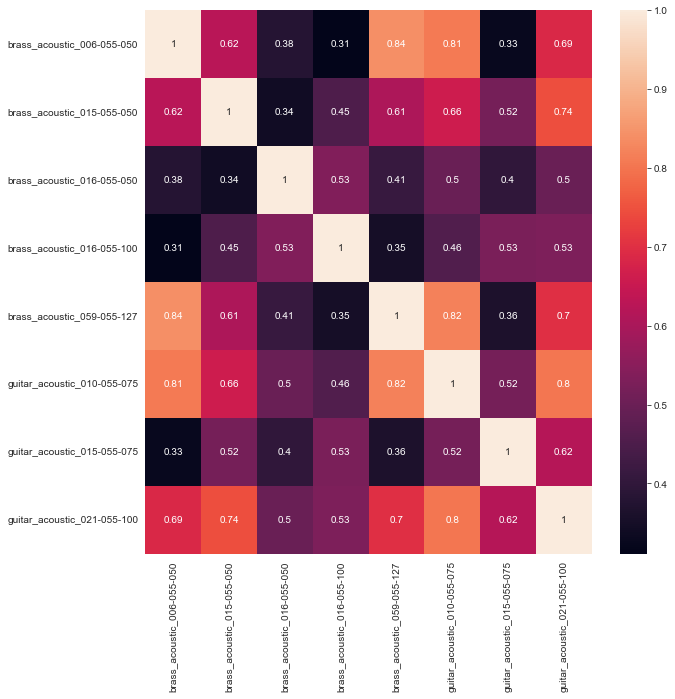

In [142]:
# display correlation matrix

res = pd.DataFrame.from_dict(corr_all)
res.sort_index(inplace=True)
res.sort_index(axis=1,inplace=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(res, annot=True,)
plt.savefig("Models/Trained/%s/correlation_matrix_055_shrinked.png" % model_path, dpi=200)

In [143]:
key_a = 'guitar_acoustic_021-055-100'
key_b = 'brass_acoustic_016-055-100'

instrument_a = np.array(embedding_dict[key_a]['emb'])
instrument_b = np.array(embedding_dict[key_b]['emb'])
power_ref_a = embedding_dict[key_a]['power_ref']
power_ref_b = embedding_dict[key_b]['power_ref']

len_a = instrument_a.shape[0]
len_b = instrument_b.shape[0]

if len_a < len_b:
    instrument_b = instrument_b[:len_a]

else:
    instrument_a = instrument_a[:len_b]

title = "%s&%s" % (key_a, key_b)
make_scatter_plot(instrument_b, instrument_a, title, key_a, key_b) # uncomment to make scatterplots between two embeddings values



In [144]:
res_emb = interpolate_spec(instrument_a, instrument_b, key_a, key_b, title, plot_original=True, i_rate=0.5, use_mel=True)

mean_power_ref = (power_ref_a + power_ref_b) / 2

decode_interpolated(folder_to_model, res_emb, title, mean_power_ref, key_a, key_b, use_mel=True, i_rate=0.5)

Decode
Feature 96 / 96
